# Overview
This notebook contains my work for modeling. In it, I do the following:
- Apply resampling to fix the class imbalance
- Set optimization priority as F1 Score to be accurate on with a minority class
- Create various models with varying hyperparameters
- Evaluate models in terms of F1 Score
- Select Logistic Regression as our best model (highest F1 Score)
- Decline to perform Grid Search due to nature of Logistic Regression hyperparameters
- Calculate ROC Curve AUC for our model

# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

import wrangle
import model

In [2]:
# import prepared data
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model()
# check import
X_train.shape, X_validate.shape, X_test.shape

Train size: (1515, 11) Validate size: (506, 11) Test size: (506, 11)


((1515, 10), (506, 10), (506, 10))

# Handling Class Imbalance
We will need to resample our training split so that the classes are balanced. This will improve the performance of our models.

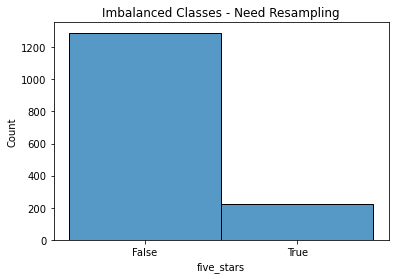

In [3]:
# display class imbalance
sns.histplot(y_train.astype('string'))
plt.title('Imbalanced Classes - Need Resampling')
plt.show()

In [4]:
# resample classes in train split
X_train, y_train = model.resampler(X_train, y_train)

Before SMOTE+Tomek applied: (1515, 10) (1515,)
After SMOTE+Tomek applied: (2578, 10) (2578,)


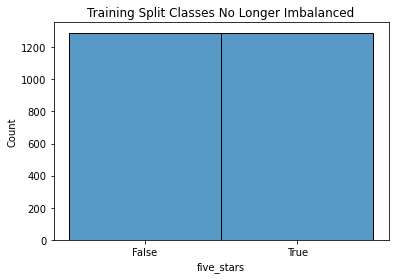

In [5]:
# show results of resampling
sns.histplot(y_train.astype('string'))
plt.title('Training Split Classes No Longer Imbalanced')
plt.show()

# Model Priorities
Before building a model, we should first consider which evaluation metric to optimize for.
1. Should we focus on capturing as many five-star reviews as possible? (Recall/Sensitivity)
2. Should we focus on limiting incorrect five-star review guesses? (Precision)
3. Should we focus on **guessing the minority class while retaining overall accuracy?** (F1 Score)
4. Should we focus on accurately classifying five-star and not-five-star reviews equally? (Accuracy)
5. Should we focus on capturing as many not-five-star reviews as possible? (Specificity)

Since our goal is to predict five-star reviews (the minority class) while being accurate overall, **we should use the F1 Score as our main evaluation metric.**

# Model Creation
Now that we've picked our main evaluation metric, this is our plan for modeling:
1. First, we will create multiple standard models from a script I created.
2. We will see which algorithms seem to perform best for F1 Score on the Validate split (our repeat-access out-of-sample split)
3. We will choose one algorithm and use Grid Search to optimize hyperparameters for F1 Score
4. We will choose 5 hyperparameter combinations and generate ROC Curves and calculate ROC AUC for each
5. We will pick the model with the highest AUC (best model)
6. Finally, evaluate model on Test split (our sequestered out-of-sample split)

## Creating Standard Classification Models - Script
My script creates the following models:
1. Choose Most Common Class as Prediction (Mode Baseline)
2. Decision Tree (DecisionTreeClassifier), max_depths = [1,2,3,5,10]
3. Random Forest (RandomForestClassifier), max_depths = [1,2,3,5,10]
4. Logistic Regression (LogisticRegression)
5. Naive Bayes (GaussianNB), smooth_levels = [.00001, .0001, .001, .01, 10, 100]
6. K-Nearest Neighbors (KNeighborsClassifier), neighbor_counts = [3,5,10,25,75]

It **fits** these models on our Train split and **generates predictions for Train and Validate** splits. Then it **returns a predictions dataframe** where the first column is the actual observed values and each additional column contains one model's predictions. **This predictions dataframe will be put through an evaluation function** in the next section.

In [6]:
# run the script
y_train_preds, y_val_preds = model.classification_shotgun(X_train, y_train, X_validate, y_validate)

Additionally, we will need to generate a column of predictions for our minority class. This will be used to compare the baseline against the models on out-of-sample data.

In [7]:
# add prediction column for five_stars = True (minority class)
y_train_preds, y_val_preds = model.manual_baseline(y_train_preds, y_val_preds, True)

Let's check to make sure everything worked properly.

In [8]:
# check the results of script for train
y_train_preds.head()

,in_actuals,mode_baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,nb_vsmooth0.001,nb_vsmooth0.01,nb_vsmooth10,nb_vsmooth100,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,manual_baseline
0,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,True
1,True,False,False,False,False,True,True,False,False,True,...,False,False,True,True,True,False,False,True,True,True
2,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,True,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,True,True,False,False,True,...,False,False,True,True,True,True,False,True,True,True


In [9]:
# check the results of script for validate
y_val_preds.head()

,out_actuals,mode_baseline,tree_maxdepth1,tree_maxdepth2,tree_maxdepth3,tree_maxdepth5,tree_maxdepth10,rf_depth1,rf_depth2,rf_depth3,...,nb_vsmooth0.001,nb_vsmooth0.01,nb_vsmooth10,nb_vsmooth100,knn_n3,knn_n5,knn_n10,knn_n25,knn_n75,manual_baseline
1264,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,True
367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1029,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,False,False,False,False,True
1391,True,False,False,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,True
527,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## First Evaluation: Initial Models and F1 Score
Now that we have predictions dataframes, we will push these dataframes through our evaluation script and check which models scored highest on F1 score.

In [10]:
# build dataframe for model performance metrics
model_performances = model.print_classification_results(y_train_preds, y_val_preds)

# sort results by top-F1 score
model_performances[['Model','OutSample_F1_Score']].sort_values(by='OutSample_F1_Score', ascending=False)

,Model,OutSample_F1_Score
11,logit,0.3841
17,nb_vsmooth100,0.3767
16,nb_vsmooth10,0.3767
8,rf_depth3,0.3734
9,rf_depth5,0.3718
12,nb_vsmooth1e-05,0.3679
14,nb_vsmooth0.001,0.3679
15,nb_vsmooth0.01,0.3679
13,nb_vsmooth0.0001,0.3679
4,tree_maxdepth5,0.3659


### Results of First Evaluation
- Always-Guess-Five-Star-Rating baseline on out-of-sample F1 Score: 28%
- Our best algorithm on out-of-sample F1 Score: Logistic Regression, F1 Score: 38%

## Second Evaluation: Grid Search
Because our best-performing algorithm is LogisticRegression, **we will not use Grid Search.** The reason for this is simple: Grid Search's main use case is iterating through numeric hyperparameter values, and Logistic Regression does not use iterative numeric values for its hyperparameters. Additionally, I've personally found hyperparameter tuning for Logistic Regression to be largely fruitless- better time would be spent on feature engineering.

Because of the lack of Grid Search usefulness for Logistic Regression and the lack of need to tune hyperparameters, we will consider Logistic Regression as our best model and calculate ROC curve AUC.

## Third Evaluation: ROC Curve AUC

In [11]:
# build, fit the best model and the baseline
bl_probs = [True for _ in range(len(y_validate))]
logit = LogisticRegression(random_state=123).fit(X_train, y_train)

In [12]:
# only use prediction percentages for five-star ratings
logit_probs = logit.predict_proba(X_validate)
logit_probs = logit_probs[:,1]

In [13]:
# calculate ROC AUC for baseline and our model
bl_auc = roc_auc_score(y_validate, bl_probs)
logit_auc = roc_auc_score(y_validate, logit_probs)

In [14]:
# print ROC AUC for baseline and our model
print('Baseline: ROC AUC=%.3f' % (bl_auc))
print('Logistic Regression: ROC AUC=%.3f' % (logit_auc))

Baseline: ROC AUC=0.500
Logistic Regression: ROC AUC=0.703


In [15]:
# generate ROC curve for baseline and best model
bl_fpr, bl_tpr, _ = roc_curve(y_validate, bl_probs)
logit_fpr, logit_tpr, _ = roc_curve(y_validate, logit_probs)

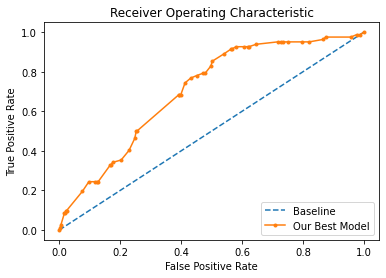

In [16]:
# plot ROC curve for baseline and best model
plt.plot(bl_fpr, bl_tpr, linestyle='--', label='Baseline')
plt.plot(logit_fpr, logit_tpr, marker='.', label='Our Best Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## Overall Results of Model Creation
> - Best Model: Logistic Regression
> - Baseline F1 Score: 28%
> - Our F1 Score: 34%
> - Baseline ROC AUC: 50%
> - Our ROC AUC: 70%

# Evaluating Best Model on Test Split
Now, we will check our best model's F1 Score for our sequestered out-of-sample split.

In [17]:
# prepare y_test for evaluation
y_test = pd.DataFrame(y_test)

In [18]:
# add columns for predictions and baseline
y_test['predictions'] = logit.predict(X_test)
y_test['baseline'] = True

In [19]:
# calculate f1 scores
baseline_f1_score = f1_score(y_test['five_stars'], y_test['baseline'])
predictions_f1_score = f1_score(y_test['five_stars'], y_test['predictions'])

In [20]:
# output f1 scores
print(f'Baseline F1 Score: {int(baseline_f1_score * 100)}%')
print(f'Best Model F1 Score: {int(predictions_f1_score * 100)}%')

Baseline F1 Score: 24%
Best Model F1 Score: 28%


# Conclusion
We selected Logistic Regression as our best model on F1 Score after resampling our training split and creating multiple models with varying hyperparameter combinations. 

We then evaluated our best model in terms of ROC Curve AUC and evaluated F1 Score for our sequestered Test split.

Overall, **our model outperforms the baseline on all metrics.**